# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1uAUJGEUzfNj6OsWNAimnYCw7eKaHhMUfU1MTj9YwYw4/edit?usp=sharing), [grading rubric](https://docs.google.com/document/d/1hKuRWqFcIdhOkow3Nljcm7PXzIkoa9c_aHkMKZDxWa0/edit?usp=sharing)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_**All code below should be consider "pseudo-code" - not functional by itself, and only an outline to help you with your own approach.**_

## Project Setup

In [70]:
# all import statements needed for the project, for example:
import math
import os
import bs4
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pyarrow.parquet as pq
import matplotlib.animation as animation
import pandas as pd
import requests
import itertools
import sqlalchemy as db
import folium
from folium.plugins import HeatMap
import geopandas as gpd
import numpy as np
import scipy.stats as st
from geopy.distance import distance

In [71]:
"""any constants you might need; some have been added for you, and some you need to fill in"""

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

TAXI_ZONES_DIR = "data/taxi_zones"
TAXI_ZONES_SHAPEFILE = "taxi_zones.shp"
UBER_CSV = ""
WEATHER_CSV_DIR = ""

CRS = 4326  # coordinate reference system

# (lat, lon)
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
LGA_BOX_COORDS = ((40.763589, -73.891745), (40.778865, -73.854838))
JFK_BOX_COORDS = ((40.639263, -73.795642), (40.651376, -73.766264))
EWR_BOX_COORDS = ((40.686794, -74.194028), (40.699680, -74.165205))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

In [72]:
"""Make sure the QUERY_DIRECTORY exists"""
try:
    os.mkdir(QUERY_DIRECTORY)
except Exception as e:
    if e.errno == 17:
        # the directory already exists
        pass
    else:
        raise

## Part 1: Data Preprocessing

### Load Taxi Zones

In [73]:
""" This function takes the shapefile and returns an object
    consisting of each zone, locationId and its geomtry coordinates """

def load_taxi_zones(shapefile: str) -> dict:
    gdf = gpd.read_file(shapefile)

    taxi_zones = []

    for index, row in gdf.iterrows():
        zone = row.iloc[3]
        locationId = row.iloc[4]
        geometry = row.iloc[6]
        
        row_object = { "zone": zone, "locationId": locationId, "geometry": geometry }
        taxi_zones.append(row_object)
    
    return taxi_zones

In [74]:
shape_data = load_taxi_zones(TAXI_ZONES_SHAPEFILE)
# There are 263 location Ids 

In [75]:
""" This function accepts the zone id and the taxi zones
    and matches the zone id with its relevant coordinates """

def lookup_coords_for_taxi_zone_id(zone_loc_id: int, loaded_taxi_zones: list) -> int:
    for i in loaded_taxi_zones:
        if i['locationId'] == zone_loc_id:
            return i['geometry']

In [76]:
""""This function creates a dictionarey with the locationids as a key and the coordinates as a value.
 We convert the polygon into actual readable coordinates and return the fictionary 
 """
def shape_dict() -> dict:

    cord = []
    for x in range(1,264): 
        cord.append(x)

    poly = []
    for x in cord:
        poly.append(lookup_coords_for_taxi_zone_id(x, shape_data))

    import pyproj
    from shapely.geometry import Point

    # Define the CRS of your input coordinates
    input_crs = 'EPSG:2263'

    # Define the CRS to which you want to convert your coordinates
    output_crs = 'EPSG:4326'

    # Create a PyProj transformer object to convert between the two CRSs
    transformer = pyproj.Transformer.from_crs(input_crs, output_crs)
    l = []
    for i in range(len(poly)):
        if i == 56 or i == 103 or i == 104:
            l.append((None,None))
        else:
            centroid2 = Point(poly[i].centroid.x, poly[i].centroid.y)
            centroid_wgs84 = transformer.transform(centroid2.x, centroid2.y)
            l.append(centroid_wgs84)

    my_dict = {index: item for index, item in enumerate(l, start=1)}

    return my_dict




In [77]:
""" test - lookup_coords_for_taxi_zone_id() """

def lookup_coords_for_taxi_zone_id_test():

    zones = [{ "zone": 3, "locationId": 1, "geometry": 5 }, { "zone": 8, "locationId": 7, "geometry": 3 }]
    assert lookup_coords_for_taxi_zone_id(1, zones)  == 5

### Calculate distance

In [78]:
""" This function calculate the distance giving the pick up
    point and drop off point and returns a distance integer """

def calculate_distance_with_coords(from_coord: tuple, to_coord: tuple) -> int:
    pickup_latitude, pickup_longitude = from_coord
    dropoff_latitude, dropoff_longitude = to_coord

    coords = [pickup_latitude, dropoff_latitude, pickup_longitude, dropoff_longitude]

    for i in coords:
        if i < -90 or i > 90:
            return -1

    return distance((pickup_latitude, pickup_longitude), (dropoff_latitude, dropoff_longitude)).miles

In [79]:
""" test - calculate_distance_with_coords() """

def calculate_distance_with_coords_test():

    from_coord = (37.7749, -12.4194)
    to_coord = (34.0522, -11.2437)
    assert round(calculate_distance_with_coords(from_coord, to_coord), 2) == 264.99


    from_coord = (105, -122.4194)
    to_coord = (34.0522, -118.2437) 
    assert calculate_distance_with_coords(from_coord, to_coord) == -1

In [80]:
""" This function adds a new column with the distance between coordinates to the Dataframe.
    The input is a dataframe and the output is the new dataframe """
 
def add_distance_column(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Apply the calculate_distance_with_coords function to each row of the DataFrame
    distances = dataframe.apply(lambda row: calculate_distance_with_coords(
        (row["pickup_latitude"], row["pickup_longitude"]),
        (row["dropoff_latitude"], row["dropoff_longitude"])
    ), axis=1)
    
    # Add the distances as a new column to the DataFrame
    dataframe["distance"] = distances
    
    return dataframe

In [81]:
""" test - add_distance_column() """

def add_distance_column_test():

    df = pd.DataFrame({
        'pickup_latitude': [40.7128],
        'pickup_longitude': [-74.006],
        'dropoff_latitude': [40.7851],
        'dropoff_longitude': [-73.9683]
    })

    df_with_distance = add_distance_column(df)

    assert "distance" in df_with_distance.columns, 'distance column is not present'

### Process Taxi Data

In [ ]:
""" This function downloads all the relevant files from the taxi webpage
    and places it into our local directory """

def download_files(month: int, year: int):
    formatted_month = f"{month:02d}"
    current_dir = os.getcwd()
    url = f"https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year}-{formatted_month}.parquet"
    
    windows = f"{current_dir}\\"
    str = windows if  os.name == 'nt' else ""

    response = requests.get(url, stream=True)
    with open(f"{str}yellow_taxi_{year}_{formatted_month}.parquet", "wb") as f:
        for chunk in response.iter_content(chunk_size=1024): 
            if chunk:
                f.write(chunk)

years = list(range(2009, 2016))
months = list(range(1, 13))

for year in years:
    if year < 2015:
        for month in months:
            download_files(month, year)
    else:
        for month in range(1, 7):
            download_files(month, year)

In [82]:
""" This function gets all the URLs from the taxi web page and returns
    it as an array of strings """

def get_all_urls_from_taxi_page(taxi_page: str) -> list[str]:
    try:
        response = requests.get(taxi_page)

        soup = bs4.BeautifulSoup(response.content, 'html.parser')
        urls = []

        for link in soup.find_all('a'):
            href = link.get('href')
            if href is not None:
                urls.append(href)

        return urls
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [83]:
"""" test for get_all_urls_from_taxi_page() """

def get_all_urls_from_taxi_page_test():

    assert len(get_all_urls_from_taxi_page(TAXI_URL)) == 483

In [84]:
""" This function goes through all the URLs on the taxi web page
    and returns only the ones ending in .parquet since we want
    parquet files and also the ones from the years 2009 to 2015
    to avoid iterating through unecessary files. """

def filter_taxi_parquet_urls(all_urls: list[str]) -> list[str]:
    parquet_urls = []
    years = list(range(2009, 2016))

    if all_urls is not None:
        for i in all_urls:
            str = re.search('.parquet$', i)

            if(str != None and "yellow_tripdata" in i):
                year = int(i.split("_")[2][:4])

                if year in years:
                    parquet_urls.append(i)
    return parquet_urls

In [85]:
""" test for filter_taxi_parquet_urls() """

def filter_taxi_parquet_urls_test():

    allUrlsData = get_all_urls_from_taxi_page(TAXI_URL)
    assert len(filter_taxi_parquet_urls(allUrlsData)) == 84

In [86]:
""" This function takes a URL and extracts the month from it
    The example url can look like:
    https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-06.parquet """

def get_and_clean_month(url: str) -> str:
    str = url[len(url) - 10:]
    [month, fileType] = str.split('.')
    return month

In [87]:
""" test for get_and_clean_month function """

def get_and_clean_month_test():

    url = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-06.parquet'
    assert get_and_clean_month(url) == '06'

In [88]:
""" This function takes a URL and extracts the year from it
    The example url can look like:
    https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-06.parquet """

def get_and_clean_year(url: str) -> str:
    str = url[len(url) - 15:]
    [year, other] = str.split('-')
    return year

In [89]:
""" test for get_and_clean_year function """

def get_and_clean_year_test():

    url = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-06.parquet'
    assert get_and_clean_year(url) == '2022'

In [90]:
""" This fucntion adds a new column with the distance between coordinates to the taxi Dataframe.
    The input is a dataframe and the output is the new modified dataframe """
 
def add_distance_column_taxi(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Apply the calculate_distance_with_coords function to each row of the DataFrame
    distances = dataframe.apply(lambda row: calculate_distance_with_coords(
        (row["Start_Lat"], row["Start_Lon"]),
        (row["End_Lat"], row["End_Lon"])
    ), axis=1)
    
    # Add the distances as a new column to the DataFrame
    dataframe["distance"] = distances
    
    return dataframe["distance"]

In [91]:
""" test - add_distance_column_taxi() """

def add_distance_column_taxi_test():

    df_taxi = pd.DataFrame({
        'Start_Lat': [40.7128],
        'Start_Lon': [-74.006],
        'End_Lat': [40.7851],
        'End_Lon': [-73.9683]
    })

    df_taxi_with_distance = add_distance_column_taxi(df_taxi)

    assert df_taxi_with_distance.shape[0] == 1
    assert isinstance(df_taxi_with_distance, pd.Series)

In [92]:
""" This function collects all the parquet urls from the taxi website.
    It will then get the actual data from the parquet files and do various forms of cleaning.
    For example, we will remove unnecessary columns and invalid data and will return
    one gigantic dataframe with data from every month """

def convert_taxi_data(parquet_urls: list[str]) -> pd.DataFrame:
    all_taxi_dataframes = []
    
    for parquet_url in parquet_urls:
        month = get_and_clean_month(parquet_url)
        year = get_and_clean_year(parquet_url)

        cwd = os.getcwd()
        files = os.listdir(cwd)

        fileName = f"yellow_taxi_{year}_{month}.parquet"
        if fileName in files :

            dataframe = pd.read_parquet(fileName)
            sample_dataframe = dataframe.sample(n=3200)
            all_taxi_dataframes.append(sample_dataframe)
        
    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes)
    return taxi_data

In [93]:
""" This function gets all the urls from the taxi page, specifically the parquet urls,
    gets and cleans it, and returns the valid data """

def get_taxi_data() -> pd.DataFrame:
    all_urls = get_all_urls_from_taxi_page(TAXI_URL)
    all_parquet_urls = filter_taxi_parquet_urls(all_urls)
    taxi_data = convert_taxi_data(all_parquet_urls)

    return taxi_data

In [94]:
"""This fucntion selects only the needed columns and dropps the rest. It also combines some columns as the data is spread across mutltiple
"""

def set_up_taxi_dataset() -> pd.DataFrame:

    selected_cols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance','PULocationID', 'DOLocationID','fare_amount','tip_amount','total_amount','pickup_datetime', 'dropoff_datetime', 'pickup_longitude', 'pickup_latitude',  'dropoff_longitude', 'dropoff_latitude', 'Trip_Pickup_DateTime', 'Trip_Dropoff_DateTime', 'Passenger_Count', 'Trip_Distance', 'Start_Lon', 'Start_Lat',  'End_Lon', 'End_Lat',  'Fare_Amt', 'Tip_Amt', 'Total_Amt']
    df_selected = get_taxi_data()
    df_selected = df_selected[selected_cols]
    # list of column pairs to join
    column_pairs = [("tpep_pickup_datetime", 'pickup_datetime'), 
                    ("tpep_dropoff_datetime", 'dropoff_datetime'),
                    ('Trip_Distance', 'trip_distance'),
                    ('Passenger_Count', 'passenger_count'),
                    ('Start_Lon', 'PULocationID'),
                    ('Start_Lat', 'PULocationID'),
                    ('End_Lon', 'DOLocationID'),
                    ('End_Lat', 'DOLocationID'),
                    ('Fare_Amt', 'fare_amount'),
                    ('Tip_Amt', 'tip_amount'),
                    ('Total_Amt', 'total_amount')]

    # loop over column pairs and join them
    for pair in column_pairs:
        # fill missing values in the first column with values from the second column
        df_selected[pair[0]] = df_selected[pair[0]].fillna(df_selected[pair[1]])
        # drop the second column
        df_selected_final = df_selected.drop(pair[1], axis=1)

    df_selected_final = df_selected_final.drop(['pickup_datetime',	'dropoff_datetime', 'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'fare_amount', 'tip_amount', 'pickup_longitude',	'pickup_latitude',	'dropoff_longitude'	,'dropoff_latitude'], axis=1)


    column_pairs = [("tpep_pickup_datetime", 'Trip_Pickup_DateTime'), 
                    ("tpep_dropoff_datetime", 'Trip_Dropoff_DateTime')]


    # loop over column pairs and join them
    for pair in column_pairs:
        # fill missing values in the first column with values from the second column
        df_selected_final[pair[0]] = df_selected_final[pair[0]].fillna(df_selected_final[pair[1]])
        # drop the second column
        df_selected_final = df_selected_final.drop(pair[1], axis=1)

        return df_selected_final



In [95]:
DF = set_up_taxi_dataset()

In [96]:
processed_taxi_data = DF.copy()


In [97]:
processed_taxi_data


tpep_pickup_datetime tpep_dropoff_datetime Trip_Dropoff_DateTime  \
2474637   2015-01-07 17:56:34   2015-01-07 18:02:18                   NaN   
10613943  2015-01-26 07:50:50   2015-01-26 08:04:51                   NaN   
1243015   2015-01-04 10:35:29   2015-01-04 10:41:45                   NaN   
11775889  2015-01-30 04:23:04   2015-01-30 05:17:46                   NaN   
7219564   2015-01-18 02:58:05   2015-01-18 03:16:59                   NaN   
...                       ...                   ...                   ...   
9112320   2009-12-26 12:52:46                   NaT   2009-12-26 12:55:51   
7250003   2009-12-19 15:44:51                   NaT   2009-12-19 16:02:58   
8635650   2009-12-18 15:33:00                   NaT   2009-12-18 15:49:00   
11416514  2009-12-06 02:03:31                   NaT   2009-12-06 02:05:06   
12798186  2009-12-19 16:27:00                   NaT   2009-12-19 16:36:00   

          Passenger_Count  Trip_Distance   Start_Lon   Start_Lat     End_Lon  \
2474637               1.0           0.90  170.000000  170.000000  233.000000   
10613943              1.0           2.20   48.000000   48.000000  140.000000   
1243015               1.0           1.18  164.000000  164.000000  230.000000   
11775889              1.0           8.40  143.000000  143.000000  129.000000   
7219564               2.0           5.10   68.000000   68.000000  236.000000   
...                   ...            ...         ...         ...         ...   
9112320               2.0           0.40  -74.002977   40.725479  -73.996073   
7250003               1.0           4.40  -73.957381   40.777250  -73.999786   
8635650               2.0           1.35  -73.962013   40.767647  -73.977462   
11416514              1.0           0.50  -73.958103   40.717547  -73.950988   
12798186              2.0           1.39  -73.978232   40.758187  -73.993322   

             End_Lat  Fare_Amt  Tip_Amt  Total_Amt  
2474637   233.000000       6.0     1.55       9.35  
10613943  140.000000      11.0     2.36      14.16  
1243015   230.000000       6.5     0.00       7.30  
11775889  129.000000      33.0     0.00      34.30  
7219564   236.000000      18.0     3.85      23.15  
...              ...       ...      ...        ...  
9112320    40.725152       3.7     0.00       4.20  
7250003    40.743499      13.7     2.84      17.04  
8635650    40.757945       9.7     0.00      10.20  
11416514   40.724287       3.7     1.17       5.87  
12798186   40.747642       6.5     0.00       7.00  

[249600 rows x 12 columns]

In [98]:
# define a function that performs the lookup operation
my_dict = shape_dict()

def lookup_lat(x):
    result = my_dict.get(x)
    if result is not None:
        return result[0]
    else:
        return x
    
# define a function that performs the lookup operation
def lookup_lon(x):
    result = my_dict.get(x)
    if result is not None:
        return result[1]
    else:
        return x

In [99]:
# apply the lookup function to all the columns in the DataFrame
#%time
processed_taxi_data["End_Lon"] = processed_taxi_data["End_Lon"].apply(lambda x: lookup_lon(x))
processed_taxi_data["Start_Lon"] = processed_taxi_data["Start_Lon"].apply(lambda x: lookup_lon(x))

processed_taxi_data["Start_Lat"] = processed_taxi_data["Start_Lat"].apply(lambda x: lookup_lat(x))
processed_taxi_data["End_Lat"] = processed_taxi_data["End_Lat"].apply(lambda x: lookup_lat(x))

In [100]:
'''
We then filter based on coordinates to make sure the rides are within the coordinates we want.
We also remove trips with 0 passangers and no fares. We further remove trips with passangers above 6 as that 
is uber policy. Lastly we remove trips with no distace between dropoff and pickup. The output is the
cleaned dataframe
'''
def filter_taxi_data() -> pd.DataFrame:

    df_selected_final = processed_taxi_data
    df_selected_final = df_selected_final[(df_selected_final["Start_Lat"] >= 40.560445) & 
                                        (df_selected_final["Start_Lon"] >= -74.242330) & 
                                        (df_selected_final["Start_Lat"] <= 40.908524) & 
                                        (df_selected_final["Start_Lon"] <= -73.717047) &
                                        (df_selected_final["End_Lat"] >= 40.560445) & 
                                        (df_selected_final["End_Lon"] >= -74.242330) & 
                                        (df_selected_final["End_Lat"] <= 40.908524) & 
                                        (df_selected_final["End_Lon"] <= -73.717047)]


    df_selected_final = df_selected_final[df_selected_final['Passenger_Count'] != 0]

    add_distance_column_taxi(df_selected_final)

    df_selected_final = df_selected_final.drop(index=df_selected_final[df_selected_final['distance'] == 0].index)

    df_selected_final = df_selected_final[df_selected_final['Passenger_Count']<=6.0]
    df_selected_final = df_selected_final.reset_index(drop=True)
    df_selected_final = df_selected_final.rename(columns={
        "tpep_pickup_datetime": "pickup_datetime",
        "tpep_dropoff_datetime": "dropoff_datetime",
        "Passenger_Count": "Passenger_Count",
        "Trip_Distance": "Trip_Distance",
        "Start_Lon": "Start_Lon",
        "Start_Lat": "Start_Lat",
        "End_Lon": "End_Lon",
        "End_Lat": "End_Lat",
        "Fare_Amt": "Fare_Amt",
        "Tip_Amt": "Tip_Amt",
        "Total_Amt": "Total_Amt",
        "distance": "distance"


    })
    df_selected_final = df_selected_final.drop('dropoff_datetime', axis=1)
    df_selected_final.rename(columns={"Trip_Dropoff_DateTime": "dropoff_datetime"})
    return df_selected_final


In [101]:
Taxi_Data = filter_taxi_data()



In [102]:
Taxi_Data

pickup_datetime Trip_Dropoff_DateTime  Passenger_Count  \
0      2015-01-07 17:56:34                   NaN              1.0   
1      2015-01-26 07:50:50                   NaN              1.0   
2      2015-01-04 10:35:29                   NaN              1.0   
3      2015-01-30 04:23:04                   NaN              1.0   
4      2015-01-18 02:58:05                   NaN              2.0   
...                    ...                   ...              ...   
196072 2009-12-26 12:52:46   2009-12-26 12:55:51              2.0   
196073 2009-12-19 15:44:51   2009-12-19 16:02:58              1.0   
196074 2009-12-18 15:33:00   2009-12-18 15:49:00              2.0   
196075 2009-12-06 02:03:31   2009-12-06 02:05:06              1.0   
196076 2009-12-19 16:27:00   2009-12-19 16:36:00              2.0   

        Trip_Distance  Start_Lon  Start_Lat    End_Lon    End_Lat  Fare_Amt  \
0                0.90 -73.978492  40.747746 -73.970443  40.749914       6.0   
1                2.20 -73.989845  40.762253 -73.954739  40.765484      11.0   
2                1.18 -73.985156  40.748575 -73.984197  40.759818       6.5   
3                8.40 -73.987646  40.775965 -73.885317  40.757312      33.0   
4                5.10 -73.999918  40.748427 -73.957012  40.780436      18.0   
...               ...        ...        ...        ...        ...       ...   
196072           0.40 -74.002977  40.725479 -73.996073  40.725152       3.7   
196073           4.40 -73.957381  40.777250 -73.999786  40.743499      13.7   
196074           1.35 -73.962013  40.767647 -73.977462  40.757945       9.7   
196075           0.50 -73.958103  40.717547 -73.950988  40.724287       3.7   
196076           1.39 -73.978232  40.758187 -73.993322  40.747642       6.5   

        Tip_Amt  Total_Amt  distance  
0          1.55       9.35  0.448103  
1          2.36      14.16  1.855286  
2          0.00       7.30  0.777433  
3          0.00      34.30  5.520613  
4          3.85      23.15  3.153669  
...         ...        ...       ...  
196072     0.00       4.20  0.363131  
196073     2.84      17.04  3.220878  
196074     0.00      10.20  1.051273  
196075     1.17       5.87  0.596507  
196076     0.00       7.00  1.075383  

[196077 rows x 12 columns]

### Processing Uber Data

In [104]:
"""This function first loads the uber data from the csv file. 
We then filter based on coordinates to make sure the rides are within the coordinates we want.
We also remove trips with 0 passangers and no fares. We further remove trips with passangers above 6 as that 
is uber policy. Lastly we remove trips with no distace between dropoff and pickup. The output is the
cleaned dataframe"""

def load_and_clean_uber_data(csv_file: str) -> pd.DataFrame:

    # Reading in file into a data frame 
    uber_data = pd.read_csv(csv_file)

    # Filter data based on pickup and dropoff latitude/longitude(40.560445, -74.242330) and (40.908524, -73.717047).

    uber_data = uber_data[(uber_data["pickup_latitude"] >= 40.560445) & 
                      (uber_data["pickup_longitude"] >= -74.242330) & 
                      (uber_data["pickup_latitude"] <= 40.908524) & 
                      (uber_data["pickup_longitude"] <= -73.717047) &
                      (uber_data["dropoff_latitude"] >= 40.560445) & 
                      (uber_data["dropoff_longitude"] >= -74.242330) & 
                      (uber_data["dropoff_latitude"] <= 40.908524) & 
                      (uber_data["dropoff_longitude"] <= -73.717047)]
    
    # Checking if there are any null values for pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
    null_drop_lat = uber_data[uber_data['dropoff_latitude'].isnull()]
    null_drop_long = uber_data[uber_data['dropoff_longitude'].isnull()]
    null_pick_lat= uber_data[uber_data['pickup_latitude'].isnull()]
    null_pick_long = uber_data[uber_data['pickup_longitude'].isnull()]

    # Return True, if none of the colums have null values 

   # if null_drop_lat.empty & null_drop_long.empty & null_pick_lat.empty & null_pick_long.empty :
        #print(True)
    #else:
       # print(False)

    
    # Removing rows where passamger count is 0 
    uber_data = uber_data[uber_data['passenger_count']!=0]


    # Removing rows with passanger data is abnormally large 
    uber_data = uber_data[uber_data['passenger_count']<=6]

    # Checking datatypes for all columns 
    #print(uber_data.dtypes)

    #Making sure pickup time is a datetime object and normalizing the name 
    uber_data ['pickup_time'] = pd.to_datetime(uber_data ['pickup_datetime'])
 
    return uber_data

In [105]:
load_and_clean_uber_data("uber_rides_sample.csv")

Unnamed: 0                            key  fare_amount  \
0         24238194    2015-05-07 19:52:06.0000003          7.5   
1         27835199    2009-07-17 20:04:56.0000002          7.7   
2         44984355   2009-08-24 21:45:00.00000061         12.9   
3         25894730    2009-06-26 08:22:21.0000001          5.3   
4         17610152  2014-08-28 17:47:00.000000188         16.0   
...            ...                            ...          ...   
199995    42598914   2012-10-28 10:49:00.00000053          3.0   
199996    16382965    2014-03-14 01:09:00.0000008          7.5   
199997    27804658   2009-06-29 00:42:00.00000078         30.9   
199998    20259894    2015-05-20 14:56:25.0000004         14.5   
199999    11951496   2010-05-15 04:08:00.00000076         14.1   

                pickup_datetime  pickup_longitude  pickup_latitude  \
0       2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1       2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2       2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3       2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4       2014-08-28 17:47:00 UTC        -73.925023        40.744085   
...                         ...               ...              ...   
199995  2012-10-28 10:49:00 UTC        -73.987042        40.739367   
199996  2014-03-14 01:09:00 UTC        -73.984722        40.736837   
199997  2009-06-29 00:42:00 UTC        -73.986017        40.756487   
199998  2015-05-20 14:56:25 UTC        -73.997124        40.725452   
199999  2010-05-15 04:08:00 UTC        -73.984395        40.720077   

        dropoff_longitude  dropoff_latitude  passenger_count  \
0              -73.999512         40.723217                1   
1              -73.994710         40.750325                1   
2              -73.962565         40.772647                1   
3              -73.965316         40.803349                3   
4              -73.973082         40.761247                5   
...                   ...               ...              ...   
199995         -73.986525         40.740297                1   
199996         -74.006672         40.739620                1   
199997         -73.858957         40.692588                2   
199998         -73.983215         40.695415                1   
199999         -73.985508         40.768793                1   

                     pickup_time  
0      2015-05-07 19:52:06+00:00  
1      2009-07-17 20:04:56+00:00  
2      2009-08-24 21:45:00+00:00  
3      2009-06-26 08:22:21+00:00  
4      2014-08-28 17:47:00+00:00  
...                          ...  
199995 2012-10-28 10:49:00+00:00  
199996 2014-03-14 01:09:00+00:00  
199997 2009-06-29 00:42:00+00:00  
199998 2015-05-20 14:56:25+00:00  
199999 2010-05-15 04:08:00+00:00  

[194786 rows x 10 columns]

In [106]:
""" We use the add distance column fcuntion we had defined before to add a new column with the distance 
of the ride to our uber data. We also drop columns where the distance of the ride is ==0"""

def get_uber_data() -> pd.DataFrame:
    uber_dataframe = load_and_clean_uber_data("uber_rides_sample.csv")
    add_distance_column(uber_dataframe)
    uber_dataframe = uber_dataframe.drop(index=uber_dataframe[uber_dataframe['distance'] == 0].index)
    uber_dataframe = uber_dataframe.drop('Unnamed: 0', axis=1)
    uber_dataframe = uber_dataframe.drop('key', axis=1)
    uber_dataframe = uber_dataframe.drop('pickup_datetime', axis=1)
    return uber_dataframe

In [107]:
final_uber_data = get_uber_data()

### Processing Weather Data

In [108]:
"""This function takes all the weather files, iterates through them and merges them 
into one dataframe. The output is the combined dataframe"""

def get_all_weather_csvs() -> pd.DataFrame:
    years = list(range(2009, 2016))

    # Initialize an empty list to store the dataframes
    dataframes = []

    # Iterate over the weather files
    for year in years:
        filepath = f"{year}_weather.csv"
        df = pd.read_csv(filepath)
        dataframes.append(df)

    # Concatenate all the dataframes into a single dataframe
    merged_df = pd.concat(dataframes, ignore_index=True)
    return merged_df

In [109]:
"""This function first loads the uber data from the csv file. 
We then filter based on coordinates to make sure the rides are within the coordinates we want.
We also remove trips with 0 passangers and no fares. We further remove trips with passangers above 6 as that 
is uber policy. Lastly we remove trips with no distace between dropoff and pickup. The output is the
cleaned dataframe"""

def load_and_clean_weather_data() -> pd.DataFrame:

    df = get_all_weather_csvs()

    df1 = df[['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'NAME','HourlyPrecipitation','HourlyWindGustSpeed', 'HourlyWindSpeed', 'DailyAverageWindSpeed','DailyPrecipitation']]
    df2 = df1.dropna(subset=['HourlyPrecipitation', 'HourlyWindGustSpeed'])

    #column_types = df2.dtypes

    #print(column_types)

    # we see that the averages for wind speed and precipitation are null for all values so we can drop the columns 

    # We also doing need the hourly wind gust speed as we will be using the hourly wind speed, we can drop that column as well

    df2 = df2.drop(columns=['DailyAverageWindSpeed','DailyPrecipitation', 'HourlyWindGustSpeed','LATITUDE', 'LONGITUDE'])
    df2['DATE'] = pd.to_datetime(df['DATE'])

    df2

    # Removing all rows where Hourly preicipitation has the value "T" as we do not need to measure trace amounts 

    df3 = df2[df2['HourlyPrecipitation'] != "T"]

    df4 = df3.drop(columns=["STATION"])

    df4 = df4.reset_index()

    df4['DATE'] = df4['DATE'].apply(lambda x: x.to_pydatetime())

    df4['DATE'] = pd.to_datetime(df4['DATE'])

    df4['HourlyPrecipitation'] = df4['HourlyPrecipitation'].str.replace(r'(\d+)\s*[sS]$', r'\1', regex=True)
    
    # convert column "A" from object to float
    df4['HourlyPrecipitation'] = df4['HourlyPrecipitation'].astype(float)

    Weather_Data = df4.drop('index', axis=1)

    return  Weather_Data

In [110]:
"""Roll up the data to daily"""
def clean_month_weather_data_daily() -> pd.DataFrame:

    daily_data = load_and_clean_weather_data()

    daily_data_final = daily_data.groupby([daily_data['DATE'].dt.year, daily_data['DATE'].dt.month, daily_data['DATE'].dt.day]).sum()[['HourlyPrecipitation', "HourlyWindSpeed" ]]

    daily_data_final = daily_data_final.rename_axis(index=['Year', 'Month', 'Day'])
    
    return daily_data_final

In [111]:
def clean_month_weather_data_hourly() -> pd.DataFrame:

    hourly_data = load_and_clean_weather_data()

    hourly_data_final = hourly_data.groupby([hourly_data['DATE'].dt.year, hourly_data['DATE'].dt.month, hourly_data['DATE'].dt.day, hourly_data['DATE'].dt.hour]).sum()[['HourlyPrecipitation', "HourlyWindSpeed" ]]

    hourly_data_final = hourly_data_final.rename_axis(index=['Year', 'Month', 'Day', 'Hour'])
    
    return hourly_data_final

In [114]:
hourly_weather_data = clean_month_weather_data_hourly()
hourly_weather_data = hourly_weather_data.reset_index()
hourly_weather_data.head()

/var/folders/4y/mgwhf9fd22746wblcfjds5gc0000gn/T/ipykernel_31473/1094114271.py:13: DtypeWarning: Columns (9,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/var/folders/4y/mgwhf9fd22746wblcfjds5gc0000gn/T/ipykernel_31473/1094114271.py:13: DtypeWarning: Columns (8,9,10,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/var/folders/4y/mgwhf9fd22746wblcfjds5gc0000gn/T/ipykernel_31473/1094114271.py:13: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/var/folders/4y/mgwhf9fd22746wblcfjds5gc0000gn/T/ipykernel_31473/1094114271.py:13: DtypeWarning: Columns (7,8,9,10,17,18,42,65) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/var/folders/4y/mgwhf9fd22746wblcfjds5gc0000gn/T/ipykernel_31473/1094114271.py:13: DtypeWarning: Columns (17,78) have mix

Year  Month  Day  Hour  HourlyPrecipitation  HourlyWindSpeed
0  2009      1    6    20                 0.01             10.0
1  2009      1    6    23                 0.02             11.0
2  2009      1    7     2                 0.09             13.0
3  2009      1    7     3                 0.06             15.0
4  2009      1    7     4                 0.07             16.0

In [115]:
daily_weather_data = clean_month_weather_data_daily()
daily_weather_data = daily_weather_data.reset_index()

daily_weather_data

/var/folders/4y/mgwhf9fd22746wblcfjds5gc0000gn/T/ipykernel_31473/1094114271.py:13: DtypeWarning: Columns (9,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/var/folders/4y/mgwhf9fd22746wblcfjds5gc0000gn/T/ipykernel_31473/1094114271.py:13: DtypeWarning: Columns (8,9,10,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/var/folders/4y/mgwhf9fd22746wblcfjds5gc0000gn/T/ipykernel_31473/1094114271.py:13: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/var/folders/4y/mgwhf9fd22746wblcfjds5gc0000gn/T/ipykernel_31473/1094114271.py:13: DtypeWarning: Columns (7,8,9,10,17,18,42,65) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/var/folders/4y/mgwhf9fd22746wblcfjds5gc0000gn/T/ipykernel_31473/1094114271.py:13: DtypeWarning: Columns (17,78) have mix

Year  Month  Day  HourlyPrecipitation  HourlyWindSpeed
0     2009      1    6                 0.03             21.0
1     2009      1    7                 1.13            224.0
2     2009      1   10                 0.06             48.0
3     2009      1   11                 0.26             67.0
4     2009      1   17                 0.69              7.0
...    ...    ...  ...                  ...              ...
1026  2015     12   26                 0.00             76.0
1027  2015     12   27                 0.02             58.0
1028  2015     12   28                 0.00             70.0
1029  2015     12   29                 0.75            167.0
1030  2015     12   31                 0.00             19.0

[1031 rows x 5 columns]

## Part 2: Storing Cleaned Data

In [117]:
engine = db.create_engine(DATABASE_URL)

In [118]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
    CREATE TABLE IF NOT EXISTS HOURLY_WEATHER (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        year INTEGER,
        month INTEGER,
        day INTEGER,
        hour INTEGER,
        precipitation REAL,
        wind REAL
);
"""

DAILY_WEATHER_SCHEMA = """
    CREATE TABLE IF NOT EXISTS DAILY_WEATHER (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        year INTEGER,
        month INTEGER,
        day INTEGER,
        precipitation REAL,
        wind REAL
    );
"""

TAXI_TRIPS_SCHEMA = """
    CREATE TABLE IF NOT EXISTS TAXI_TRIPS (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        pickup_datetime DATETIME,
        Trip_Dropoff_DateTime DATETIME
        Passenger_Count REAL
        Trip_Distance REAL,
        Start_Lon REAL,
        Start_Lat REAL,
        End_Lon REAL, 
        End_Lat REAL,
        Fare_Amt REAL, 
        Tip_Amt REAL, 
        Total_Amt REAL,
        distance REAL,

    );
"""

UBER_TRIPS_SCHEMA = """
    CREATE TABLE IF NOT EXISTS UBER_TRIPS (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        fare_amount REAL,
        pickup_longitude REAL,
        pickup_latitude REAL,
        dropoff_longitude REAL,
        dropoff_latitude REAL,
        passenger_count INTEGER,
        pickup_time DATETIME,
        distance REAL,
    );
"""


In [119]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [120]:
# create the tables with the schema files
with engine.connect() as connection:
    pass

### Add Data to Database

In [121]:
def write_dataframes_to_table():

    hourly_weather_data.to_sql(name='HOURLY_WEATHER', con=engine, if_exists='replace', index=False)
    daily_weather_data.to_sql(name='DAILY_WEATHER', con=engine, if_exists='replace', index=False)
    final_uber_data.to_sql(name='UBER_TRIPS', con=engine, if_exists='replace', index=False)
    Taxi_Data.to_sql(name='TAXI_TRIPS', con=engine, if_exists='replace', index=False)

write_dataframes_to_table()

In [122]:
from sqlalchemy import create_engine

# establish a connection to the SQL database
engine = create_engine(DATABASE_URL)

# execute a SELECT query on the HOURLY_WEATHER table
query = "SELECT * FROM TAXI_TRIPS LIMIT 10;"
result = engine.execute(query)

for row in result:
    print(row)

('2015-01-07 17:56:34.000000', None, 1.0, 0.9, -73.97849158432054, 40.74774573203895, -73.97044261148469, 40.74991400028384, 6.0, 1.55, 9.35, 0.448102502395496)
('2015-01-26 07:50:50.000000', None, 1.0, 2.2, -73.98984489812494, 40.76225259858687, -73.9547390603464, 40.76548395144242, 11.0, 2.36, 14.16, 1.8552861119473414)
('2015-01-04 10:35:29.000000', None, 1.0, 1.18, -73.98515644835915, 40.74857453693654, -73.98419655675737, 40.759817566309465, 6.5, 0.0, 7.3, 0.7774332769569512)
('2015-01-30 04:23:04.000000', None, 1.0, 8.4, -73.9876456908124, 40.77596514731965, -73.88531729044865, 40.75731177578825, 33.0, 0.0, 34.3, 5.5206132301277195)
('2015-01-18 02:58:05.000000', None, 2.0, 5.1, -73.99991779023728, 40.7484273300986, -73.95701192571859, 40.78043629001211, 18.0, 3.85, 23.15, 3.1536690476617673)
('2015-01-05 08:20:21.000000', None, 1.0, 6.5, -74.0078796687525, 40.71777262479923, -73.97619875860275, 40.640589941044496, 20.5, 0.0, 21.3, 5.5797257900769806)
('2015-01-19 14:23:14.000000

## Part 3: Understanding the Data

In [123]:
# Helper function to write the queries to file
def write_query_to_file(query, outfile):
    raise NotImplementedError()

### Query 1

In [124]:
from sqlalchemy import create_engine

# establish a connection to the SQL database
engine = create_engine(DATABASE_URL)

# execute a SELECT query on the HOURLY_WEATHER table

with open('1_hour_day.sql', 'r') as file:
    query = file.read()

result = engine.execute(query)

for row in result:
    print(row)

('19', 12282)
('20', 11717)
('18', 11711)
('21', 11441)
('22', 11077)
('14', 9888)
('23', 9781)
('17', 9771)
('12', 9499)
('15', 9475)
('13', 9376)
('11', 9109)
('09', 9100)
('08', 8844)
('10', 8759)
('16', 7985)
('00', 7725)
('07', 7232)
('01', 5746)
('02', 4254)
('06', 4057)
('03', 3035)
('04', 2292)
('05', 1921)


### Query 2

In [125]:
from sqlalchemy import create_engine

# establish a connection to the SQL database

engine = create_engine(DATABASE_URL)

# execute a SELECT query on the HOURLY_WEATHER table

with open('2_day_week.sql', 'r') as file:
    
    query = file.read()

result = engine.execute(query)


for row in result:
    print(row)

('Sunday', 25503)
('Monday', 24280)
('Tuesday', 27152)
('Wednesday', 27971)
('Thursday', 28960)
('Friday', 29749)
('Saturday', 29214)


### Query 3

In [126]:
from sqlalchemy import create_engine

# establish a connection to the SQL database
engine = create_engine(DATABASE_URL)

# execute a SELECT query on the HOURLY_WEATHER table

with open('3_95_percentile.sql', 'r') as file:
    query = file.read()

result = engine.execute(query)

for row in result:
    print(row)

(16.7641931513008,)


### Query 4

In [127]:
from sqlalchemy import create_engine

# establish a connection to the SQL database
engine = create_engine(DATABASE_URL)

# execute a SELECT query on the HOURLY_WEATHER table

with open('4_top_10_days.sql', 'r') as file:
    query = file.read()

result = engine.execute(query)

for row in result:
    print(row)

('2009-12-11', 246, 1.9804287687342412)
('2009-01-31', 238, 1.8516577841861095)
('2009-04-23', 233, 1.822345996389474)
('2009-12-10', 230, 2.010338010663224)
('2009-07-31', 229, 1.8568540392764135)
('2009-04-18', 228, 1.916082417420244)
('2009-02-12', 228, 1.9484418365846143)
('2009-09-11', 227, 1.733889098548231)
('2009-04-24', 227, 2.11737657082534)
('2009-03-12', 227, 1.967415928587705)


### Query 5

In [129]:
from sqlalchemy import create_engine

# establish a connection to the SQL database
engine = create_engine(DATABASE_URL)

# execute a SELECT query on the HOURLY_WEATHER table

with open('5_10_windiest_days.sql', 'r') as file:
    query = file.read()

result = engine.execute(query)

for row in result:
    print(row)

('2014-10-22', 165, 220.0)
('2014-11-18', 185, 194.0)
('2014-12-25', 71, 191.0)
('2014-11-26', 157, 175.0)
('2014-12-18', 190, 162.0)
('2014-12-10', 191, 159.0)
('2014-12-13', 202, 152.0)
('2014-12-12', 235, 128.0)
('2014-11-21', 205, 127.0)
('2014-12-23', 147, 105.0)


### Query 6

In [137]:
from sqlalchemy import create_engine

# establish a connection to the SQL database
engine = create_engine(DATABASE_URL)

# execute a SELECT query on the HOURLY_WEATHER table

with open('6_hurricane.sql', 'r') as file:
    query = file.read()

result = engine.execute(query)

for row in result:
    print(row)





(2012, 10, 22, 12, 0.0, 11.0, 15, 15)
(2012, 10, 27, 21, 0.0, 9.0, 42, 42)
(2012, 10, 28, 3, 0.0, 9.0, 0, 0)
(2012, 10, 28, 4, 0.0, 10.0, 0, 0)
(2012, 10, 28, 5, 0.0, 11.0, 0, 0)
(2012, 10, 28, 6, 0.0, 10.0, 0, 0)
(2012, 10, 28, 7, 0.0, 11.0, 0, 0)
(2012, 10, 28, 8, 0.0, 11.0, 0, 0)
(2012, 10, 28, 9, 0.0, 11.0, 0, 0)
(2012, 10, 28, 10, 0.0, 10.0, 10, 10)
(2012, 10, 28, 11, 0.0, 8.0, 10, 10)
(2012, 10, 28, 12, 0.0, 7.0, 6, 6)
(2012, 10, 28, 13, 0.0, 13.0, 9, 9)
(2012, 10, 28, 14, 0.0, 13.0, 30, 30)
(2012, 10, 28, 15, 0.0, 13.0, 18, 18)
(2012, 10, 28, 16, 0.0, 16.0, 20, 20)
(2012, 10, 28, 17, 0.0, 11.0, 4, 4)
(2012, 10, 28, 18, 0.0, 15.0, 5, 5)
(2012, 10, 28, 19, 0.0, 14.0, 9, 9)
(2012, 10, 28, 20, 0.0, 16.0, 4, 4)
(2012, 10, 28, 21, 0.0, 14.0, 6, 6)
(2012, 10, 28, 22, 0.0, 16.0, 9, 9)
(2012, 10, 28, 23, 0.0, 14.0, 0, 1)
(2012, 10, 29, 0, 0.0, 16.0, 0, 0)
(2012, 10, 29, 1, 0.0, 11.0, 0, 0)
(2012, 10, 29, 2, 0.0, 13.0, 0, 0)
(2012, 10, 29, 3, 0.0, 17.0, 0, 0)
(2012, 10, 29, 4, 0.0, 15.0, 

In [77]:
engine.execute(QUERY_1).fetchall()

NameError: name 'QUERY_1' is not defined

In [ ]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

## Part 4: Visualizing the Data

### Visualization 1

In [116]:
def plot_frequency_hour(dataframe: pd.DataFrame):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    hour = dataframe['Hour'].tolist()
    values = dataframe['Frequency'].tolist()

    axes.bar(hour, values)

    axes.set_ylabel('Frequency')
    axes.set_xlabel('Hour')
    axes.set_title("Frequency per Hour")
    
    plt.show()

In [117]:
def get_data_frequency_hour():

    with open('1_hour_day.sql', 'r') as file:
        query = file.read()

    result = engine.execute(query)

    hour = []
    frequency = []

    for row in result:
        hour.append(row[0])
        frequency.append(row[1])

    df = pd.DataFrame({'Hour': hour, 'Frequency': frequency})

    return df


In [118]:
get_data_frequency_hour()

Hour  Frequency
0    19       2406
1    18       2360
2    20       2148
3    21       2109
4    22       2094
5    17       1951
6    14       1865
7    15       1857
8    23       1834
9    12       1809
10   13       1776
11   09       1737
12   11       1697
13   16       1648
14   08       1632
15   10       1610
16   00       1491
17   07       1277
18   01       1122
19   02        813
20   06        738
21   03        609
22   04        451
23   05        323

In [119]:
some_dataframe = get_data_frequency_hour()
plot_frequency_hour(some_dataframe)

<IPython.core.display.Javascript object>

### Visualization 2

In [120]:
def plot_avg_distance_month(dataframe: pd.DataFrame):
    figure, axes = plt.subplots(figsize=(30, 20))
    
    month = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
    distance = dataframe['Average Distance'].tolist()
    x = np.linspace(0, 12, 12) 

    a, b = np.polyfit(x, distance, deg=1)
    y_est = a * x + b
    y_err = x.std() * np.sqrt(1/len(x) +
                            (x - x.mean())**2 / np.sum((x - x.mean())**2))

    axes.plot(x, y_est, '-')

    axes.plot(month, distance, 'o', color='tab:brown')
    axes.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    axes.set_ylabel('Average Distance')
    axes.set_xlabel('Month')
    axes.set_title("Average Distance per Month")

    plt.show()

In [121]:
def get_data_avg_distance_month():
    
    query = """
        SELECT     
            strftime('%m', trips.pickup_time) AS month,
            AVG(trips.distance) AS avg_distance
        FROM 
            (SELECT pickup_time, distance FROM UBER_TRIPS
            UNION ALL
            SELECT pickup_datetime, distance FROM TAXI_TRIPS) trips
        GROUP BY month
    """

    result = engine.execute(query)

    month = []
    average_distance = []

    for row in result:
        if row[0] is not None:
            month.append(row[0])
            average_distance.append(row[1])

    df = pd.DataFrame({'Month': month, 'Average Distance': average_distance})

    return df

In [122]:
get_data_avg_distance_month()

Month  Average Distance
0     01          1.961722
1     02          1.986988
2     03          2.020031
3     04          2.053736
4     05          2.131949
5     06          2.098942
6     07          2.095253
7     08          2.112952
8     09          2.093273
9     10          2.082157
10    11          2.075976
11    12          2.029634

In [123]:
some_dataframe = get_data_avg_distance_month()
plot_avg_distance_month(some_dataframe)

<IPython.core.display.Javascript object>

### Visualization 3

In [124]:
def plot_dropoffs_ny_area(dataframe: pd.DataFrame):

    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    lga = dataframe['LGA'].tolist()
    jfk = dataframe['JFK'].tolist()
    ewr = dataframe['EWR'].tolist()

    x_axis = np.arange(len(days))
  
    plt.bar(x_axis - 0.2, lga, 0.4, label = 'LGA')
    plt.bar(x_axis + 0.2, jfk, 0.4, label = 'JFK')
    plt.bar(x_axis + 0.4, ewr, 0.4, label = 'EWR')

    plt.xlabel("Days in Week")
    plt.ylabel("Drop Offs")
    plt.title("Drop-Offs per Airport")

    plt.xticks(x_axis, days)
    plt.tight_layout()

    plt.legend()
    plt.show()

In [130]:
def get_data_dropoffs_ny_area():

    query = """
        SELECT pickup_datetime,
            CASE 
                WHEN (End_Lon BETWEEN -73.840942 AND -73.731079 AND End_Lat BETWEEN 40.614738 AND 40.685547) THEN 'JFK'
                WHEN (End_Lon BETWEEN -74.222717 AND -74.127960 AND End_Lat BETWEEN 40.662338 AND 40.724777) THEN 'EWR'
                WHEN (End_Lon BETWEEN -73.903027 AND -73.847580 AND End_Lat BETWEEN 40.759704 AND 40.794002) THEN 'LGA'
            END AS airport,
            strftime('%w', pickup_datetime) as day_of_week
        FROM TAXI_TRIPS
        UNION
        SELECT pickup_time,
            CASE 
                WHEN (dropoff_longitude BETWEEN -73.840942 AND -73.731079 AND dropoff_latitude BETWEEN 40.614738 AND 40.685547) THEN 'JFK'
                WHEN (dropoff_longitude BETWEEN -74.222717 AND -74.127960 AND dropoff_latitude BETWEEN 40.662338 AND 40.724777) THEN 'EWR'
                WHEN (dropoff_longitude BETWEEN -73.903027 AND -73.847580 AND dropoff_latitude BETWEEN 40.759704 AND 40.794002) THEN 'LGA'
            END AS airport,
            strftime('%w', pickup_time) as day_of_week
        FROM UBER_TRIPS
    """

    result = engine.execute(query)

    frequency_dict = {'JFK': {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0},
                  'EWR': {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0},
                  'LGA': {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0}}
    
    for row in result:
        airport = row[1]
        day_of_week = row[2]
        if day_of_week is not None and airport is not None:
            frequency_dict[airport][day_of_week] += 1

    ewr = [value for value in frequency_dict['EWR'].values()]
    jfk = [value for value in frequency_dict['JFK'].values()]
    lga = [value for value in frequency_dict['LGA'].values()]

    df = pd.DataFrame({'EWR': ewr, 'JFK': jfk, 'LGA': lga})

    return df

In [131]:
get_data_dropoffs_ny_area()

EWR  JFK  LGA
0   68  308  452
1   47  261  473
2   39  248  402
3   52  261  490
4   45  309  523
5   40  295  572
6   38  248  303

In [132]:
some_dataframe = get_data_dropoffs_ny_area()
plot_dropoffs_ny_area(some_dataframe)

<IPython.core.display.Javascript object>

### Visualization 4

In [133]:
def plot_trips_area(coords: list[list]):    
    map_obj = folium.Map(location = [40.730610, -73.935242], zoom_start = 10, min_zoom = 10, tiles='CartoDB positron')

    HeatMap(coords).add_to(map_obj)
    return map_obj

In [134]:
def get_data_trips_area():

    query = """
        SELECT End_Lat, End_Lon
        FROM TAXI_TRIPS
        UNION
        SELECT dropoff_latitude, dropoff_longitude
        FROM UBER_TRIPS;
    """

    result = engine.execute(query)

    coordinates = []

    for row in result:
        coordinates.append(list(row))
    
    return coordinates

In [92]:
get_data_trips_area()

[[40.561228, -73.911748],
 [40.562571000000005, -74.11041],
 [40.563715, -73.810827],
 [40.564327, -74.1068],
 [40.565217, -74.113326],
 [40.569052, -73.975887],
 [40.57172, -74.120035],
 [40.57254, -73.989912],
 [40.57271, -74.22723],
 [40.573643, -74.13769499999998],
 [40.573733, -73.847763],
 [40.574037, -74.226568],
 [40.575187, -73.853465],
 [40.575328, -74.00761199999998],
 [40.575363, -73.963002],
 [40.575697, -74.00805],
 [40.575743, -73.957197],
 [40.576125, -74.044358],
 [40.576207, -73.968248],
 [40.57636, -73.98474499999999],
 [40.576418, -73.967487],
 [40.576472, -73.968602],
 [40.576521, -73.959549],
 [40.576631, -73.95863199999998],
 [40.576651, -73.959416],
 [40.576669, -73.961149],
 [40.576762, -73.968523],
 [40.577057, -73.953603],
 [40.57712, -73.96338],
 [40.577325, -73.957175],
 [40.57736, -73.965334],
 [40.577492, -73.968643],
 [40.577507, -73.955265],
 [40.577512, -73.990352],
 [40.577675, -73.95673000000001],
 [40.578078000000005, -73.954121],
 [40.5782020000000

In [93]:
some_dataframe = get_data_trips_area()
plot_trips_area(some_dataframe)

### Visualization 5

In [94]:
def plot_tips_distance(dataframe: pd.DataFrame):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    tips = dataframe['Tip'].tolist()
    distance = dataframe['Distance'].tolist()

    axes.scatter(distance, tips, marker='o', alpha=0.5)
    axes.set_title("Yellow Tips - Tips vs. Distance")
    axes.set_ylabel('Popularity')
    axes.set_xlabel('Distance')
    
    plt.show()

In [95]:
def get_data_tips_distance():

    query = """
        SELECT ROUND(distance, 2) AS distance, Tip_Amt
        FROM TAXI_TRIPS
    """

    result = engine.execute(query)

    distance = []
    tip = []

    for row in result:
        distance.append(row[0])
        tip.append(row[1])

    df = pd.DataFrame({'Distance': distance, 'Tip': tip})

    return df

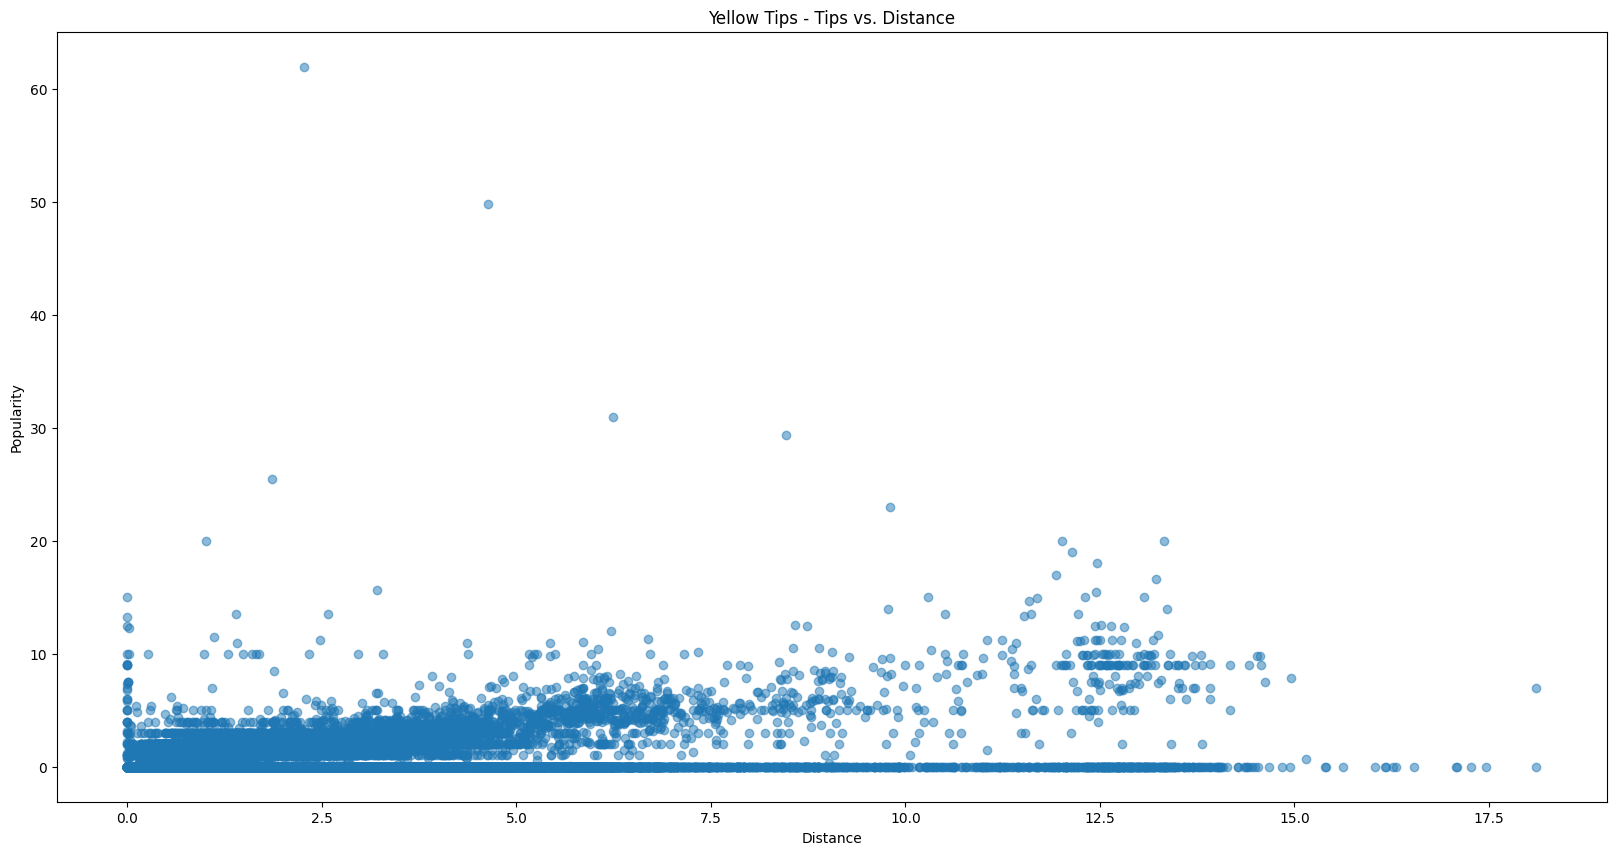

In [96]:
some_dataframe = get_data_tips_distance()
plot_tips_distance(some_dataframe)

### Visualization 6

In [97]:
%matplotlib notebook

In [98]:
def plot_tips_precipitation(dataframe: pd.DataFrame):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    tips = dataframe['Tip'].tolist()
    precipication = dataframe['Precipication'].tolist()

    ## Animation

    frames = 10
    points = len(tips)
    np.random.seed(42)

    sizes = itertools.cycle([10, 50, 150])
    colors = np.random.rand(frames, points)
    colormaps = itertools.cycle(['Purples', 'Blues', 'Greens', 'Oranges', 'Reds'])
    markers = itertools.cycle(['o', 'v', '^', 's', 'p'])

    def update(i):
        axes.clear()

        axes.scatter(precipication, tips,
                s=next(sizes),
                c=colors[i, :],
                cmap=next(colormaps),
                marker=next(markers),
                alpha=0.5)

        axes.set_title("Yellow Taxi - Tips vs. Precipitation")
        axes.set_xlabel('Precipitation')
        axes.set_ylabel('Tips')

    anim = animation.FuncAnimation(figure, update, frames=frames, interval=500)
    anim
    plt.show()

In [154]:
def get_data_tips_precipitation():
    
    query = """
        SELECT h.HourlyPrecipitation, t.Tip_Amt
        FROM HOURLY_WEATHER h
        JOIN TAXI_TRIPS t ON strftime('%Y-%m-%d %H:00:00', t.pickup_datetime) = strftime('%Y-%m-%d %H:00:00', datetime(h.year || '-' || h.month || '-' || h.day || ' ' || h.hour || ':00:00'));
        LIMIT 50
    """

    result = engine.execute(query)

    precipication = []
    tip = []

    for row in result:
        precipication.append(row[0])
        tip.append(row[1])

    df = pd.DataFrame({'Precipication': precipication, 'Tip': tip})

    return df

In [155]:
get_data_tips_precipitation()

OperationalError: (sqlite3.OperationalError) no such column: h.year
[SQL: 
        SELECT h.HourlyPrecipitation, t.Tip_Amt
        FROM HOURLY_WEATHER h
        JOIN TAXI_TRIPS t ON strftime('%Y-%m-%d %H:00:00', t.pickup_datetime) = strftime('%Y-%m-%d %H:00:00', datetime(h.year || '-' || h.month || '-' || h.day || ' ' || h.hour || ':00:00'));
        LIMIT 50
    ]
(Background on this error at: https://sqlalche.me/e/14/e3q8)

In [201]:
some_dataframe = get_data_tips_precipitation()
plot_tips_precipitation(some_dataframe)